In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose

# Loading Data

In [2]:
df = pd.read_csv("FinalProject-Singapore.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df.columns

Index(['STI_Price', 'SPY_Price', 'SHG_Price', 'US Interest Rates',
       'China Interest Rates ', 'Production Index United States',
       'Production Index China', 'Date', 'CNY', 'USD'],
      dtype='object')

In [4]:
cols_to_plot = ['STI_Price', 'SPY_Price', 'SHG_Price', 'US Interest Rates',
                'China Interest Rates ', 'Production Index United States',
                'Production Index China', 'CNY', 'USD']
return_cols_to_plot = []

for col in cols_to_plot:
    return_cols_to_plot.append(col+"_returns")

#### D(1) - Returns Data

In [5]:
for col in cols_to_plot:
    df[f'{col}_returns'] = df[col].pct_change().fillna(0)

# Data Exploration

## Description of Data
**Singapore**
* STI: Singapore FTSE Straight Times Index (Investing.com)

**United States**
* SPY: S&P 500 Prices (Investing.com)
* US Interest Rates: Discount Rate (FRED)
* Production Index United States: Production: Industry: Total Industry Excluding Construction for United States (FRED)
* USD: How many Singpaore dollars are needed to purchase a US Dollar (Investing.com)

**China**
* SHG: Shanghai Composite Index Prices
* Chinese Interest Rates: Discount Rate (FRED)
* Production Index China: Production: Industry: Total Industry Excluding Construction for United China (FRED)
* CNY: How many Singpaore dollars are needed to purchase a Chinese Yen

## Observing Data

#### Frequency Distribution

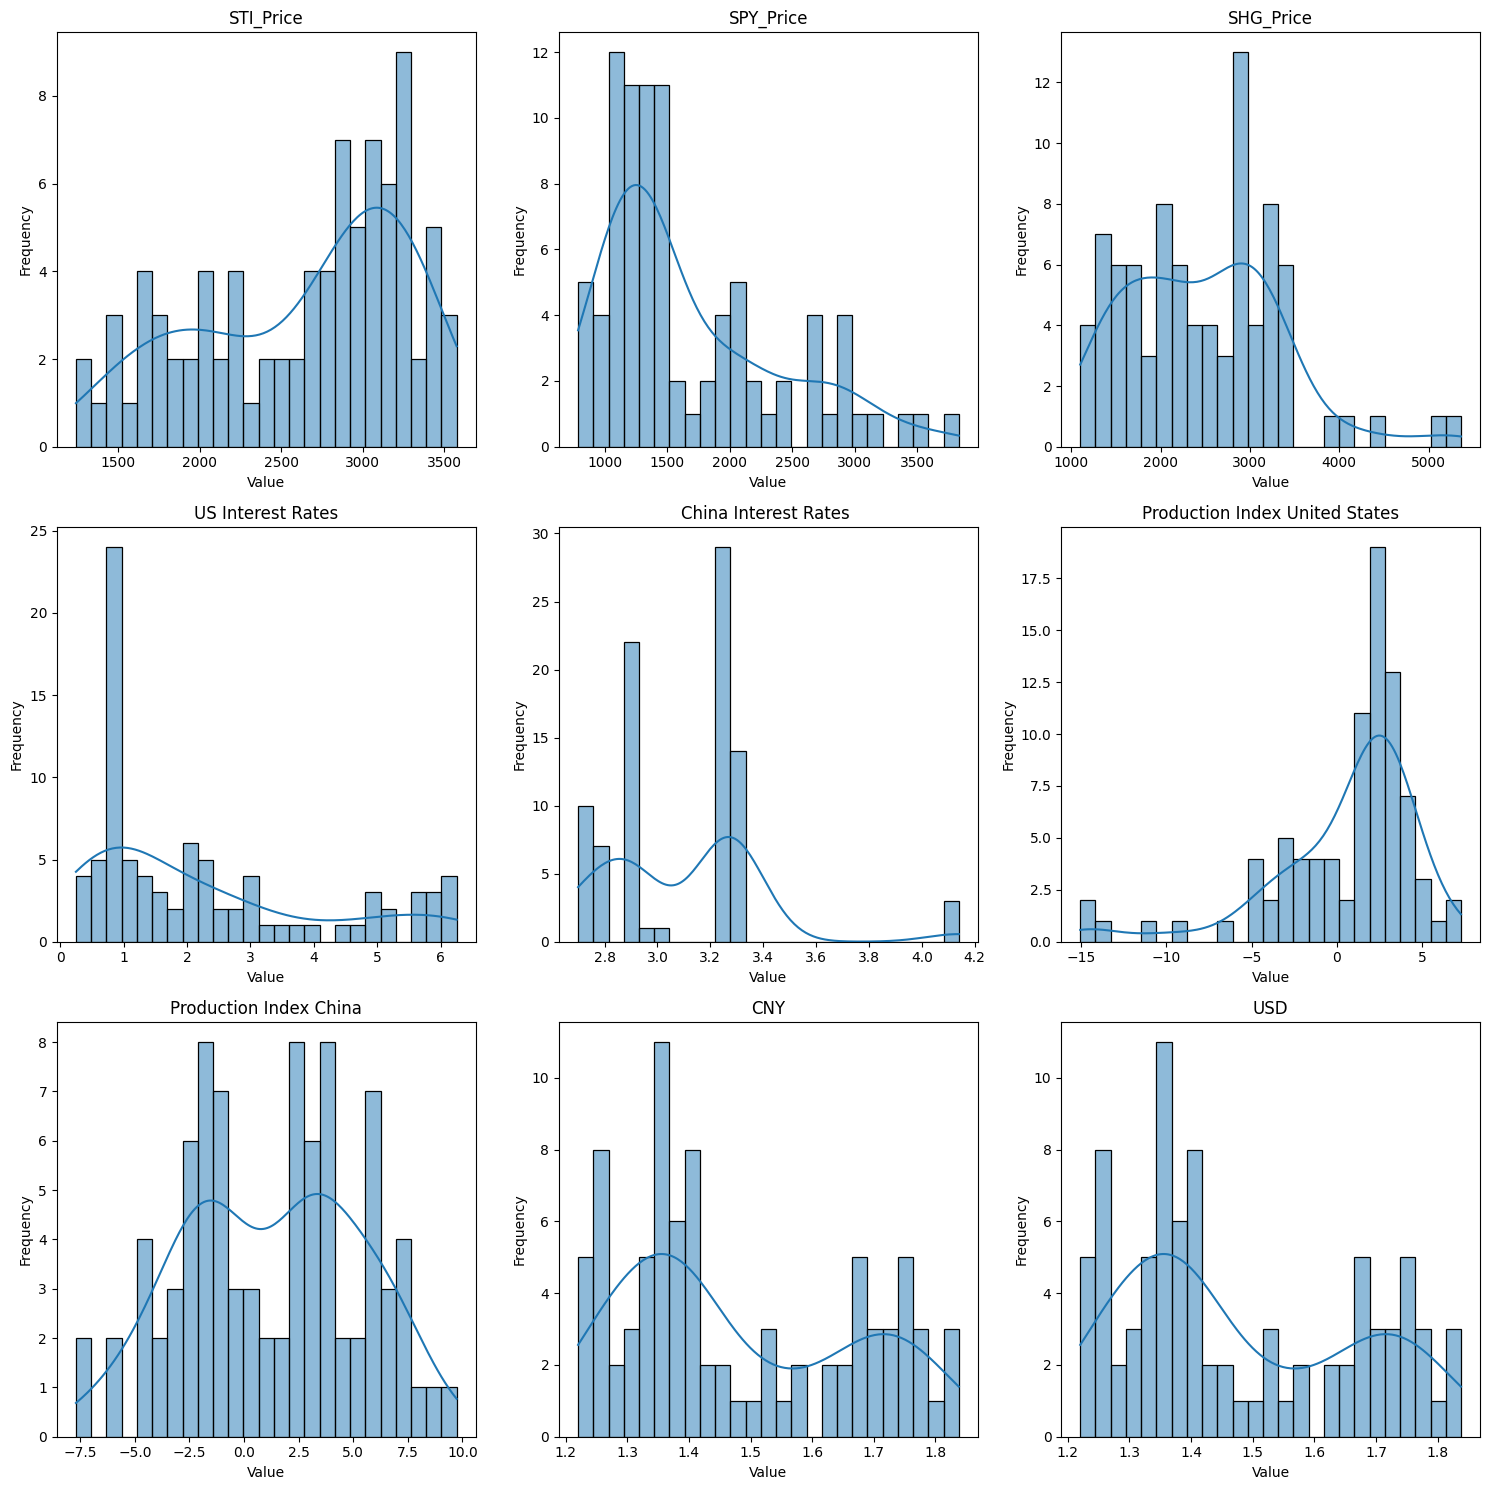

In [6]:


n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col], ax=axes[i], kde=True, bins=25)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# If there are any leftover axes, turn them off
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Over Time

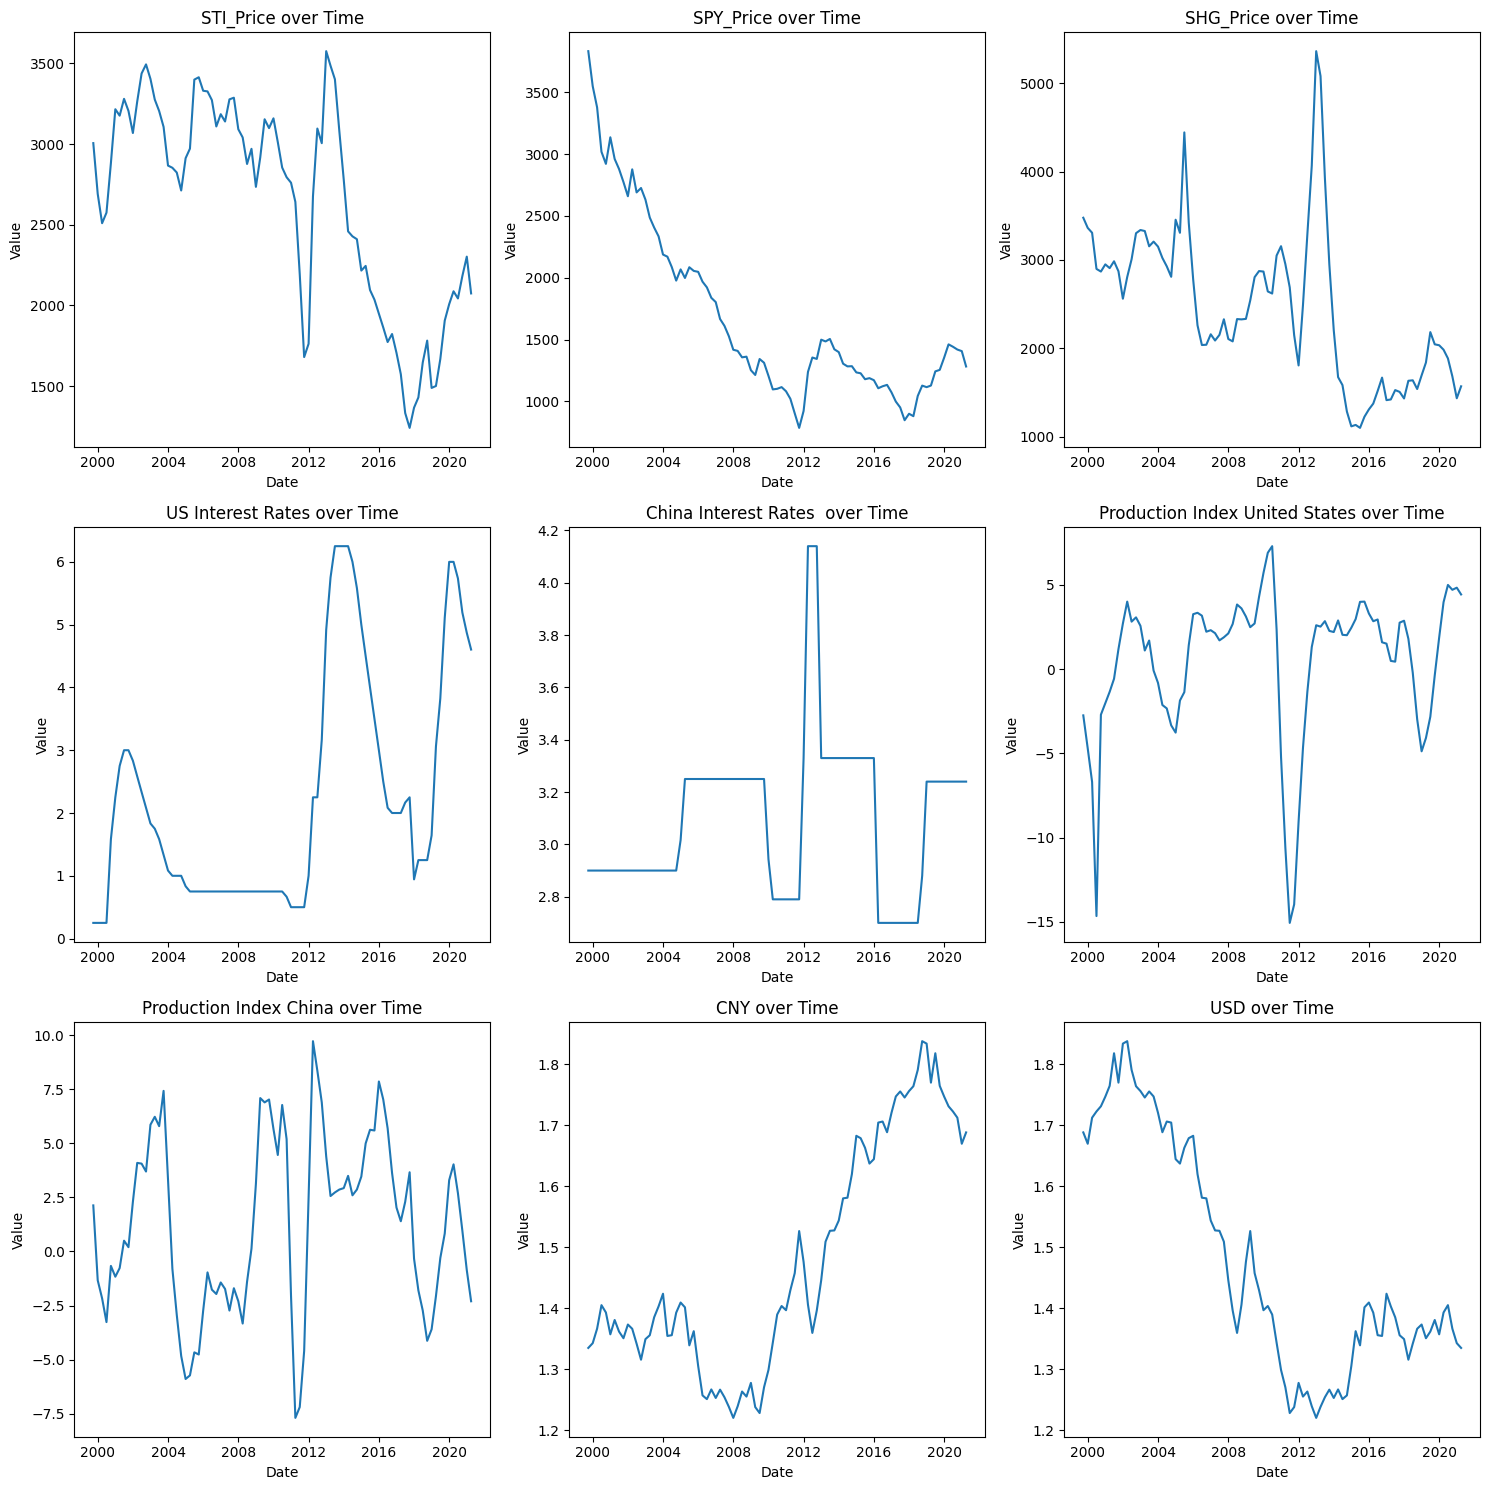

In [7]:


n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols_to_plot):
    sns.lineplot(x=df['Date'], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} over Time")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')

# If there are any leftover axes, turn them off
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Returns

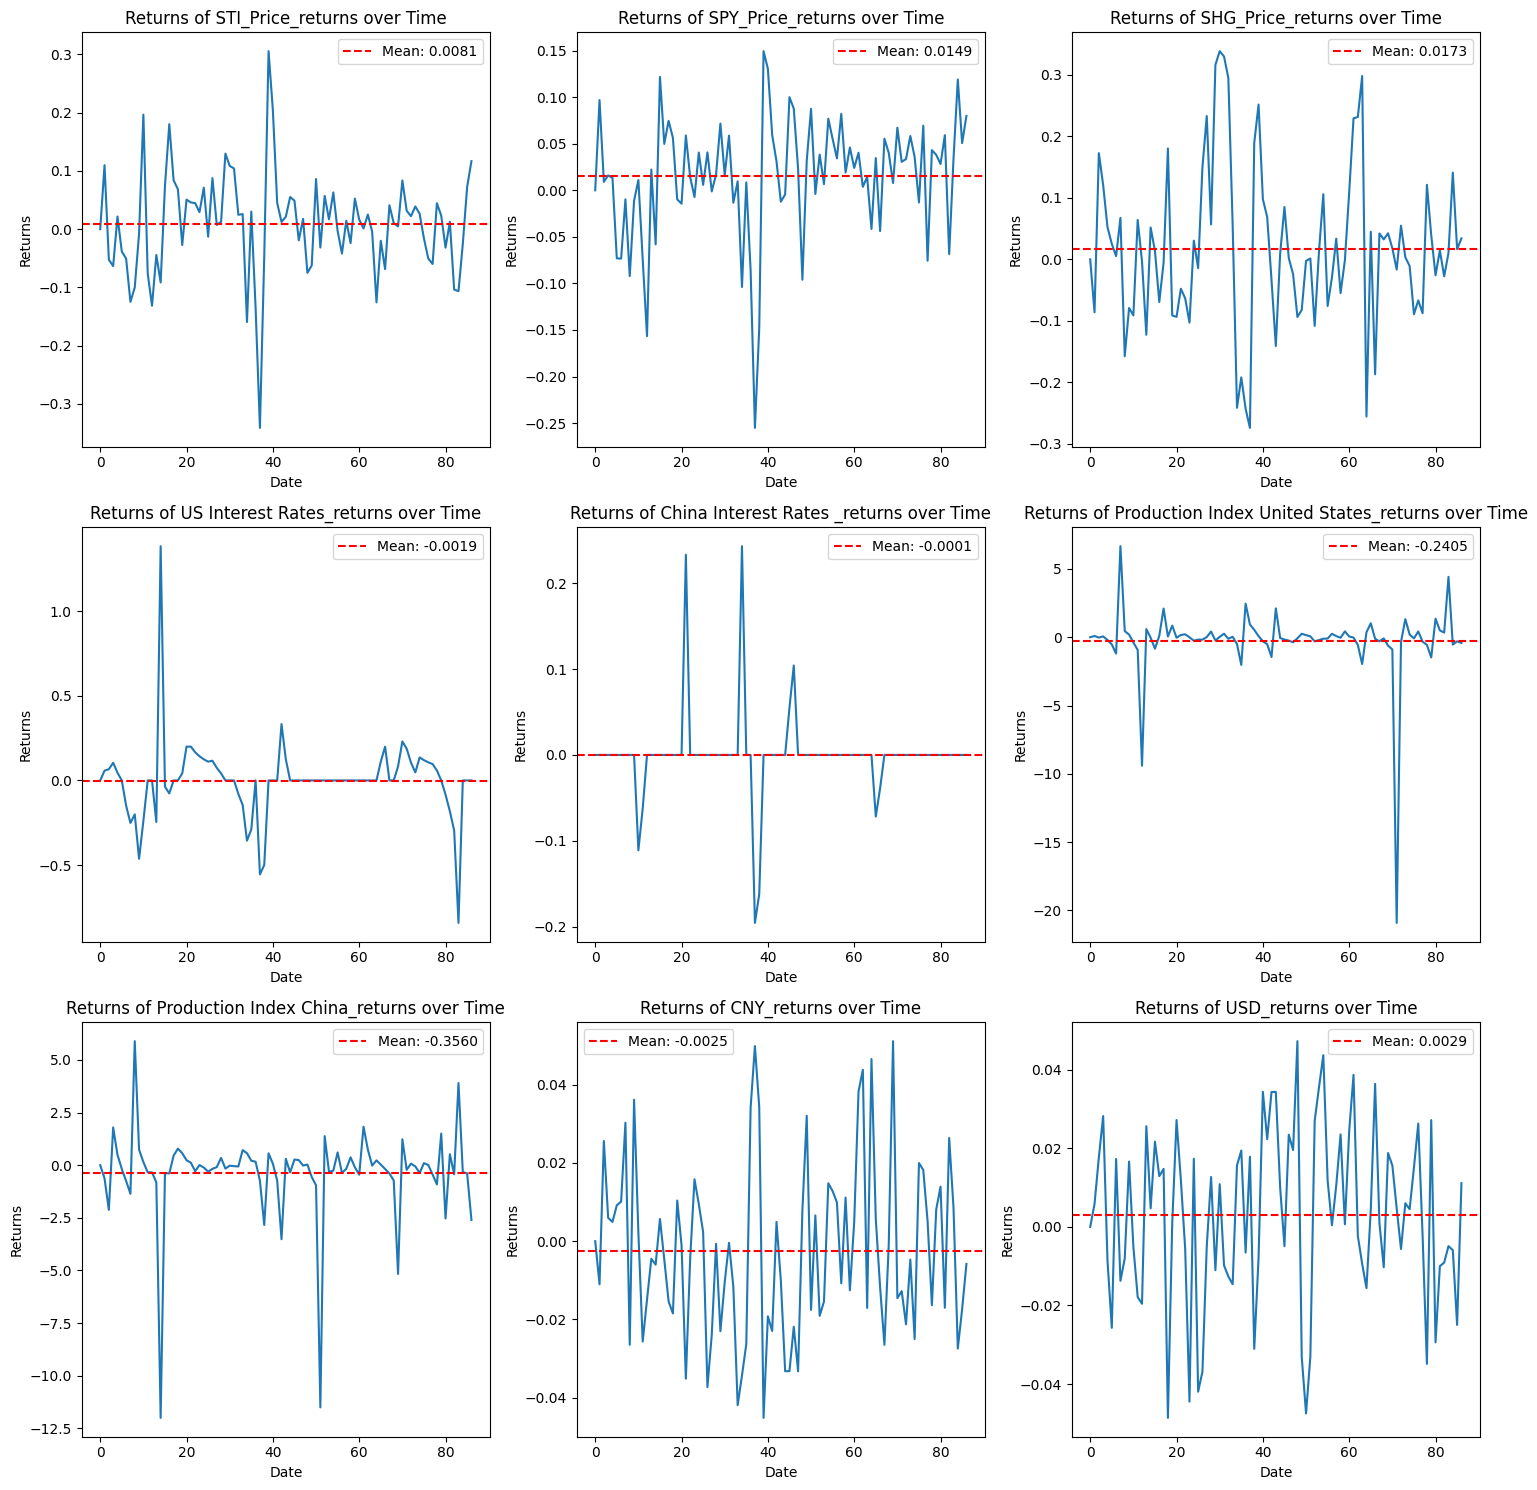

In [8]:

n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.lineplot(data=df, x=df.index, y=col+'_returns', ax=axes[i])
    mean_return = df[col+'_returns'].mean()  # Calculate the mean return for the column
    axes[i].axhline(mean_return, color='red', linestyle='--', label=f'Mean: {mean_return:.4f}')
    axes[i].set_title(f"Returns of {col+'_returns'} over Time")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Returns')
    axes[i].legend()  # Show the legend

# Remove any leftover axes
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Frequency Distribution - Returns

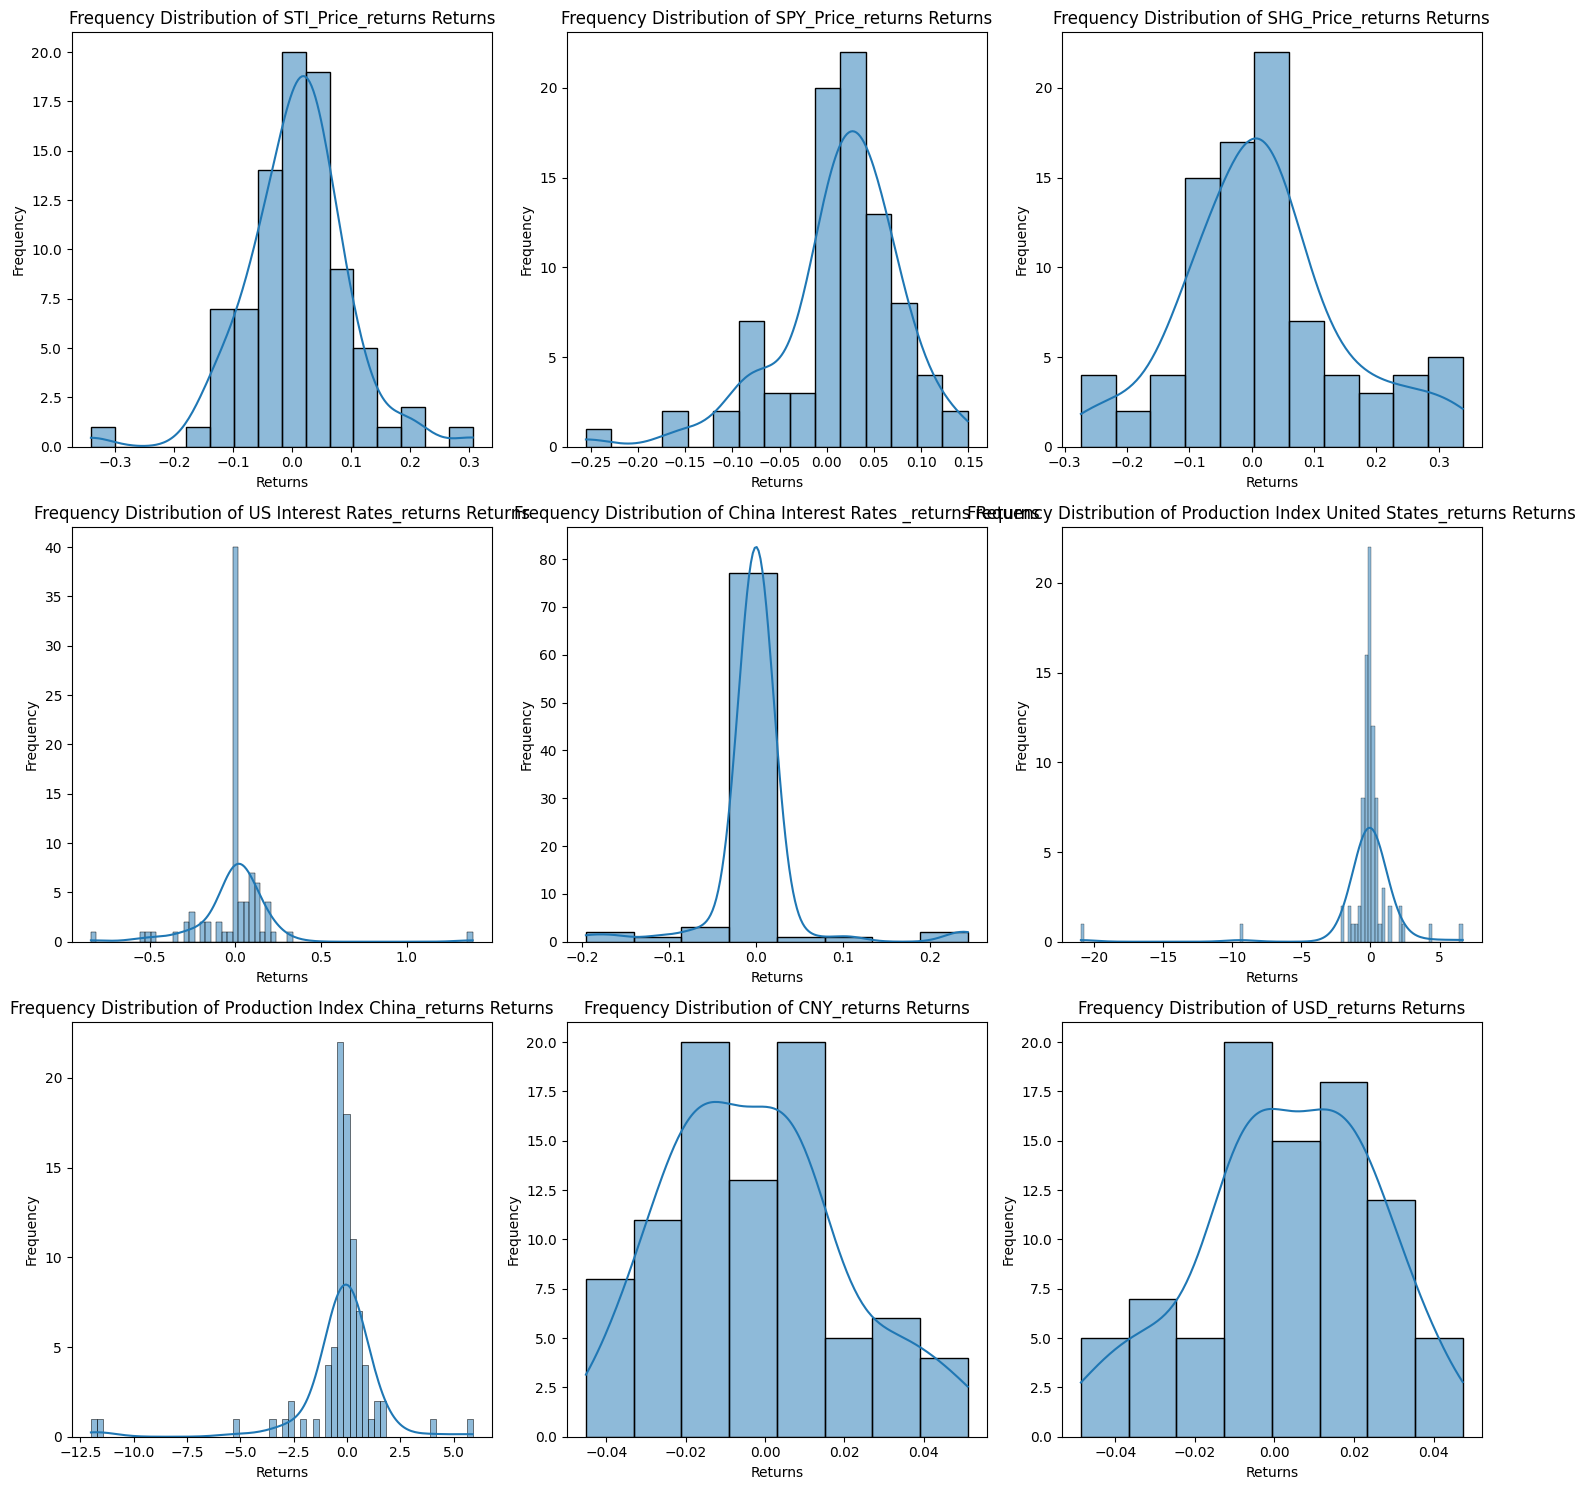

In [9]:
# Plotting frequency distributions
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col+'_returns'], kde=True, ax=axes[i])  # You can use histplot for histograms
    axes[i].set_title(f"Frequency Distribution of {col+'_returns'} Returns")
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Frequency')

# Remove any leftover axes
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Testing Stationary - Unit Root Tests & Decreasing Autocorrellations
*kpss is a proxy of decreasing autocorrelations*

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

# Define a function to perform the ADF test on a series
def perform_adf_test(series):
    result = adfuller(series)
    return {'ADF Statistic': result[0], 'p-value (ADF)': result[1], **result[4]}

# Define a function to check stationarity based on both ADF and KPSS
def is_stationary(row):
    adf_statistic = row['ADF Statistic']
    adf_p_value = row['p-value (ADF)']
    kpss_p_value = row['p-value (KPSS)']
    
    return adf_p_value < 0.05 and adf_statistic < row['1%'] and kpss_p_value > 0.05

# Initialize a list to hold test results
results = []
d1_results = []

# Perform ADF and KPSS tests on each series and store the results in the 'results' list
for col in cols_to_plot:
    adf_result = perform_adf_test(df[col])
    kpss_result = kpss(df[col])
    results.append({**adf_result, 'p-value (KPSS)': kpss_result[1], 'Stationary': is_stationary({**adf_result, 'p-value (KPSS)': kpss_result[1]})})


for col in return_cols_to_plot:
    adf_result = perform_adf_test(df[col])
    kpss_result = kpss(df[col])
    d1_results.append({**adf_result, 'p-value (KPSS)': kpss_result[1], 'Stationary': is_stationary({**adf_result, 'p-value (KPSS)': kpss_result[1]})})

# Convert the results to a DataFrame
stationary_results_df = pd.DataFrame(results, index=cols_to_plot)
stationary_d1_results_df = pd.DataFrame(d1_results, index=return_cols_to_plot)

C:\Users\Charl\AppData\Local\Temp\ipykernel_14996\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df[col])
C:\Users\Charl\AppData\Local\Temp\ipykernel_14996\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df[col])
C:\Users\Charl\AppData\Local\Temp\ipykernel_14996\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df[col])
C:\Users\Charl\AppData\Local\Temp\ipykernel_14996\1193116427.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greate

In [11]:
# Display the DataFrame
print("ADF and KPSS Test Results (D(0)):")
stationary_results_df.sort_values(by="ADF Statistic")

ADF and KPSS Test Results (D(0)):


,ADF Statistic,p-value (ADF),1%,5%,10%,p-value (KPSS),Stationary
Production Index United States,-4.738997,0.000071,-3.510712,-2.896616,-2.585482,0.100000,True
US Interest Rates,-3.702849,0.004073,-3.511712,-2.897048,-2.585713,0.024704,False
China Interest Rates,-3.566120,0.006443,-3.509736,-2.896195,-2.585258,0.100000,True
Production Index China,-2.570815,0.099180,-3.518281,-2.899878,-2.587223,0.100000,False
STI_Price,-2.058086,0.261699,-3.509736,-2.896195,-2.585258,0.010000,False
SHG_Price,-1.998478,0.287241,-3.512738,-2.897490,-2.585949,0.010718,False
CNY,-1.189168,0.678238,-3.510712,-2.896616,-2.585482,0.010000,False
USD,-0.731810,0.838337,-3.509736,-2.896195,-2.585258,0.010000,False
SPY_Price,2.977513,1.000000,-3.508783,-2.895784,-2.585038,0.010000,False


In [12]:
print("\nADF Test on Returns Data (D(1)):")
stationary_d1_results_df.sort_values(by="ADF Statistic")


ADF Test on Returns Data (D(1)):


,ADF Statistic,p-value (ADF),1%,5%,10%,p-value (KPSS),Stationary
Production Index China_returns,-9.380165,6.992015e-16,-3.508783,-2.895784,-2.585038,0.1,True
Production Index United States_returns,-8.913760,1.086592e-14,-3.508783,-2.895784,-2.585038,0.1,True
USD_returns,-7.637972,1.929603e-11,-3.508783,-2.895784,-2.585038,0.1,True
US Interest Rates_returns,-7.257332,1.717181e-10,-3.508783,-2.895784,-2.585038,0.1,True
SPY_Price_returns,-6.911232,1.210916e-09,-3.508783,-2.895784,-2.585038,0.1,True
STI_Price_returns,-6.741941,3.102912e-09,-3.509736,-2.896195,-2.585258,0.1,True
CNY_returns,-6.571515,7.914444e-09,-3.509736,-2.896195,-2.585258,0.1,True
China Interest Rates _returns,-6.152980,7.484435e-08,-3.510712,-2.896616,-2.585482,0.1,True
SHG_Price_returns,-5.366548,3.980530e-06,-3.511712,-2.897048,-2.585713,0.1,True


## Correllation Matrices

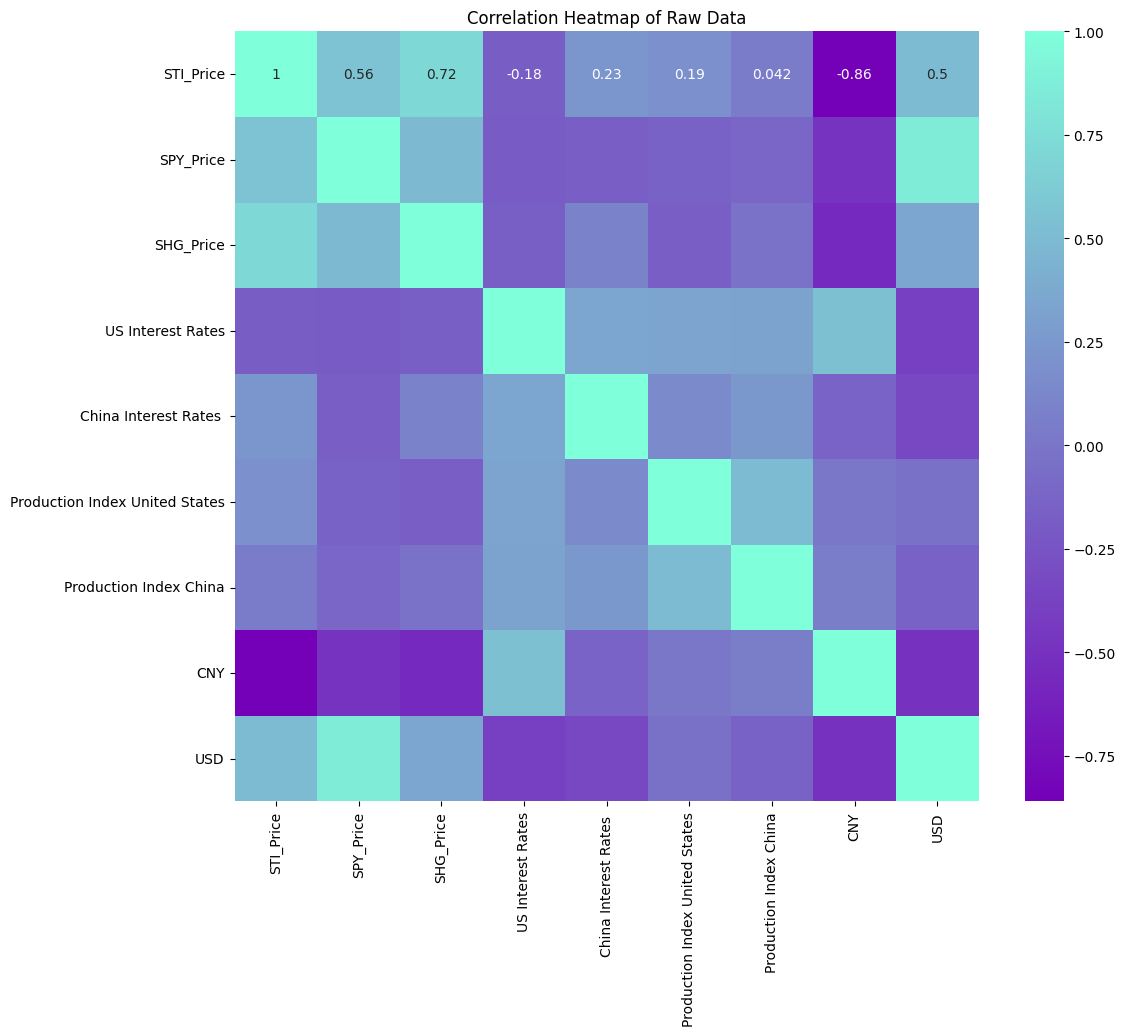

In [13]:
colors = ["#7400b8", "#80ffdb"]  # Add more colors as desired

# Create the colormap
mint_cmap = LinearSegmentedColormap.from_list("mint_cmap", colors)

corr_matrix_raw = df[cols_to_plot].corr()

corr_matrix_returns = df[return_cols_to_plot].corr()

# Plotting the heatmaps
plt.figure(figsize=(12, 10))

# Heatmap for raw data
sns.heatmap(corr_matrix_raw, annot=True, cmap=mint_cmap)
plt.title('Correlation Heatmap of Raw Data')
plt.show()


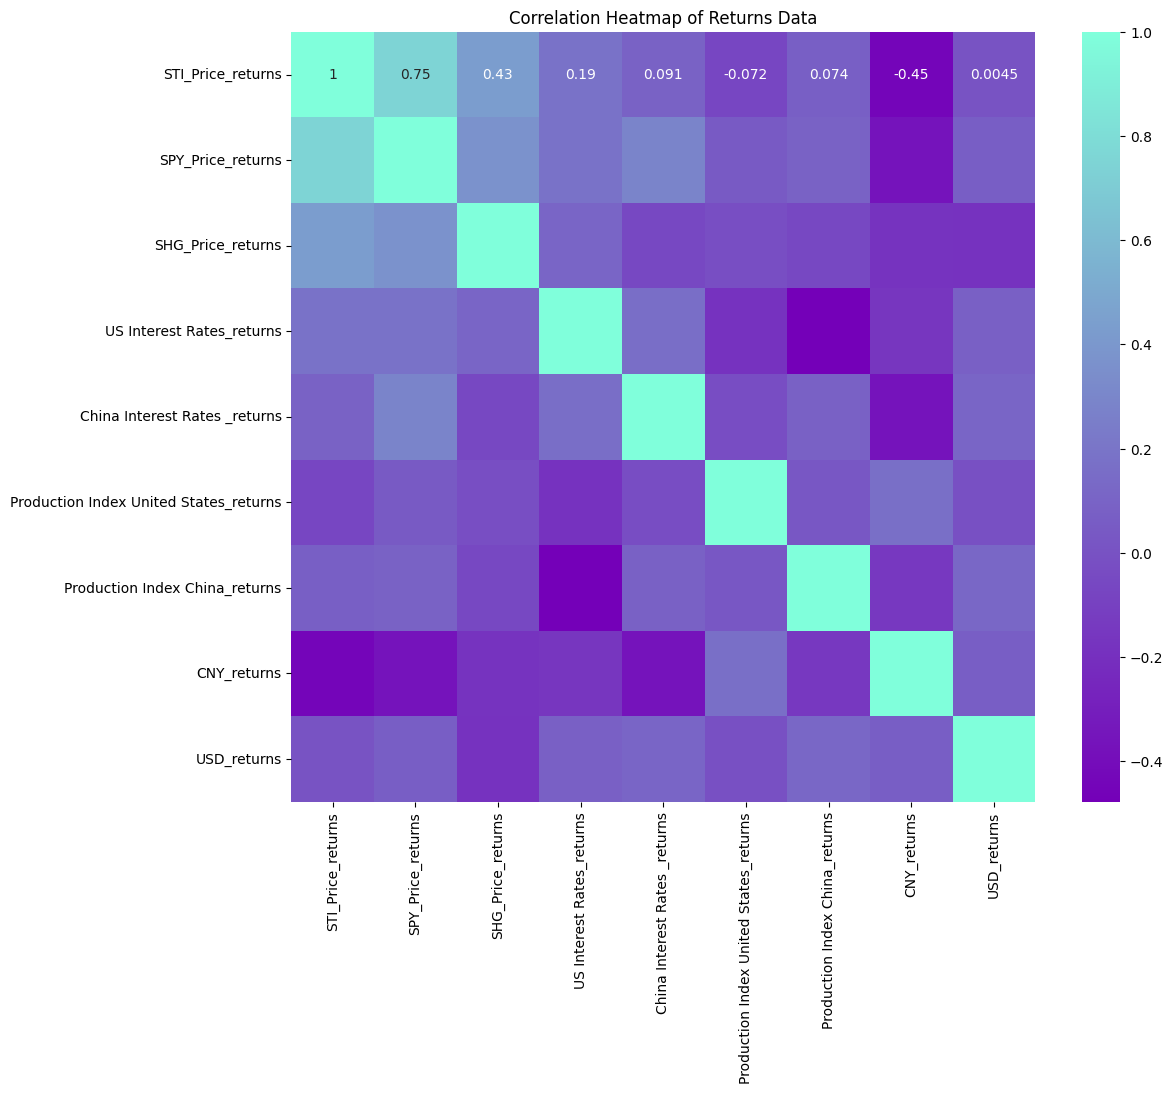

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_returns, annot=True, cmap=mint_cmap)
plt.title('Correlation Heatmap of Returns Data')
plt.show()

# Research

## Granger Causality

In [15]:
pairs = [
    ('STI_Price', 'SHG_Price'),
    ('SHG_Price', 'STI_Price'),
    ('CNY', 'STI_Price'),
    ('STI_Price', 'CNY'),
    ('STI_Price', 'USD'),
    ('USD', 'STI_Price'),
    ('STI_Price', 'SPY_Price'),
    ('SPY_Price', 'STI_Price')
]

In [16]:
def run_granger_causality_tests(df, pairs, maxlag=4):
    """
    Run Granger Causality tests for each pair of variables in the DataFrame.

    Parameters:
    df -- pandas DataFrame containing the time series data
    pairs -- list of tuples, each tuple containing two strings representing the variable names
    maxlag -- integer, the maximum number of lags to test for

    Returns:
    A pandas DataFrame with the Granger Causality test results.
    """
    granger_test_results = []

    for dependent, independent in pairs:
        test_result = grangercausalitytests(df[[dependent, independent]], maxlag=maxlag, verbose=False)
        min_p_value = min(test_result[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag + 1))

        granger_test_results.append({
            'dependent': dependent,
            'independent': independent,
            'min_p_value': min_p_value
        })

    granger_df = pd.DataFrame(granger_test_results)
    granger_df["granger_causes"] = granger_df["min_p_value"] <= 0.10

    return granger_df

granger_df = run_granger_causality_tests(df, pairs)

c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Charl\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  

In [17]:
granger_df.sort_values("min_p_value", ascending=True)

,dependent,independent,min_p_value,granger_causes
3,STI_Price,CNY,0.012595,True
5,USD,STI_Price,0.080366,True
1,SHG_Price,STI_Price,0.088542,True
0,STI_Price,SHG_Price,0.100203,False
7,SPY_Price,STI_Price,0.150524,False
2,CNY,STI_Price,0.452324,False
4,STI_Price,USD,0.639058,False
6,STI_Price,SPY_Price,0.680263,False


## Cointegration and Error Correction

In [18]:
cointegration_test_results = []
for dependent, independent in pairs:
    # Retrieve the time series for each variable
    ts_dependent = df[dependent].values
    ts_independent = df[independent].values
    
    # Perform the cointegration test
    coint_t, p_value, _ = coint(ts_dependent, ts_independent)
    
    # Append the results to the list
    cointegration_test_results.append({
        'dependent': dependent,
        'independent': independent,
        'tau-statistic': coint_t,
        'p-value': p_value
    })
cointegration_df = pd.DataFrame(cointegration_test_results)

cointegration_df["cointegrated"] = (cointegration_df["p-value"] <= 0.05) & (cointegration_df["tau-statistic"] < -2)

In [19]:
cointegration_df.sort_values("cointegrated", ascending=False)

,dependent,independent,tau-statistic,p-value,cointegrated
1,SHG_Price,STI_Price,-3.765525,0.015059,True
2,CNY,STI_Price,-3.541558,0.028885,True
3,STI_Price,CNY,-4.142986,0.004443,True
0,STI_Price,SHG_Price,-2.743502,0.184324,False
4,STI_Price,USD,-2.464919,0.294756,False
5,USD,STI_Price,-1.450324,0.779744,False
6,STI_Price,SPY_Price,-2.124480,0.463579,False
7,SPY_Price,STI_Price,1.563380,1.000000,False


## VAR Model

### Functions & Variables

In [20]:
def fit_var_and_select_best_aic(df, variable_list, maxlags_list=[1, 2, 4, 8, 12]):
    """
    Fit VAR models to the specified variables within the dataframe for a set of lags.
    Select the model with the lowest AIC.
    
    Parameters:
    df -- pandas DataFrame containing the time series data
    variable_list -- list of column names to be included in the VAR model
    maxlags_list -- list of integers for the maximum lag order to consider
    
    Returns:
    A tuple containing the best AIC value and the corresponding VARResults object
    """
    best_aic = float('inf')
    best_model = None
    df_selected_vars = df[variable_list].dropna()
    
    for lags in maxlags_list:
        model = VAR(df_selected_vars)
        results = model.fit(maxlags=lags, ic='aic')
        print(lags, results.aic)
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
    
    return best_aic, best_model

In [21]:
USA_cols = ['STI_Price_returns', 'SPY_Price_returns', 'US Interest Rates_returns', 'Production Index United States_returns', 'USD_returns']
CHN_cols = ['STI_Price_returns', 'SHG_Price_returns', 'CNY_returns', 'Production Index China_returns', 'China Interest Rates _returns']

### Determining Optimal Lag Length

In [22]:
_, chn_model = fit_var_and_select_best_aic(df, CHN_cols)

1 -21.769155681606758
2 -21.769155681606758
4 -21.769155681606758
8 -21.769155681606758
12 -22.54251101900715


In [23]:
_, usa_model = fit_var_and_select_best_aic(df, USA_cols)

1 -19.81835111138833
2 -19.81835111138833
4 -19.81835111138833
8 -19.81835111138833
12 -21.115173839808925


### Impulse Reponse 

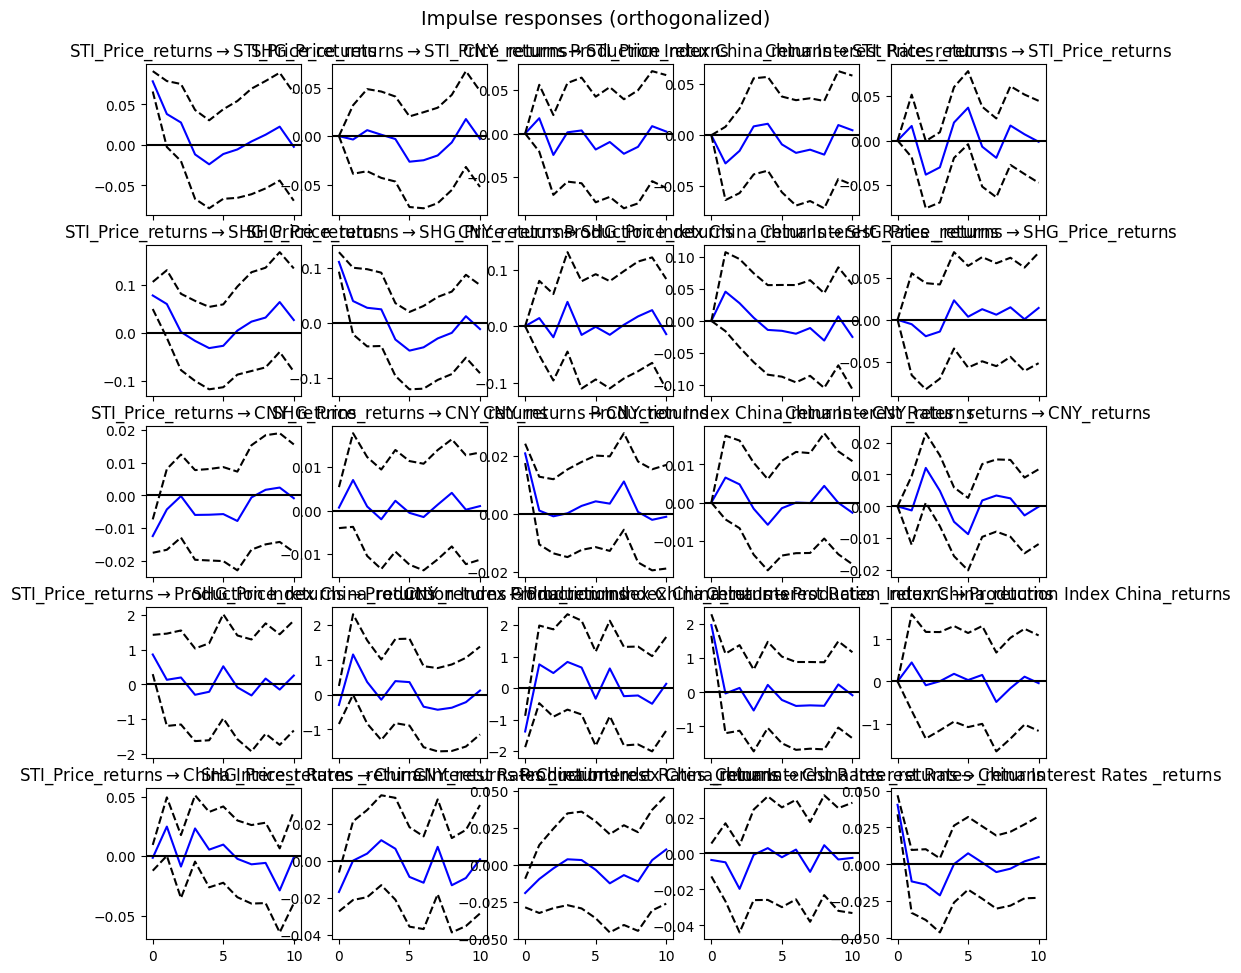

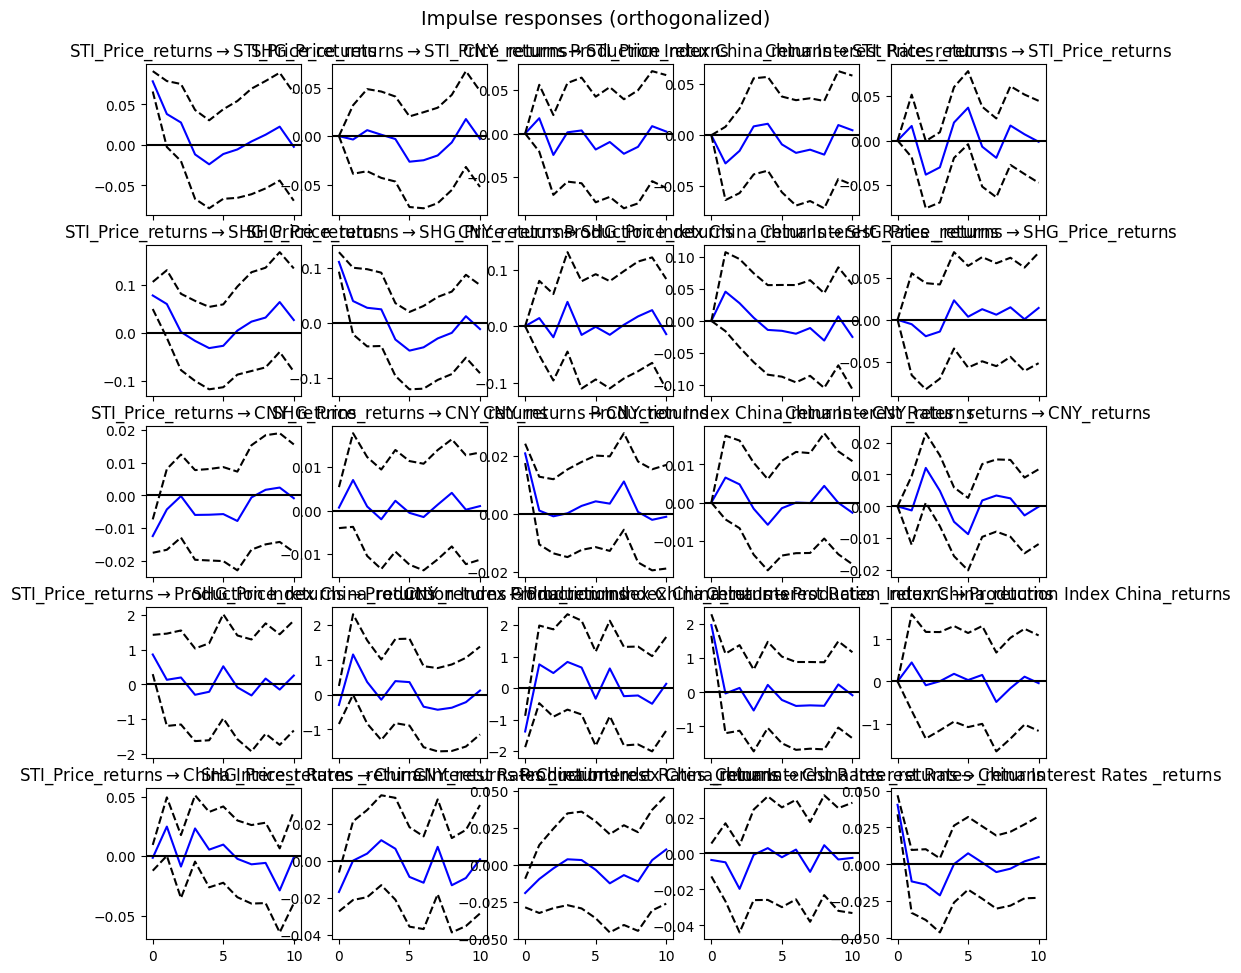

In [24]:
china_irf = chn_model.irf(10)

china_irf.plot(orth=True)

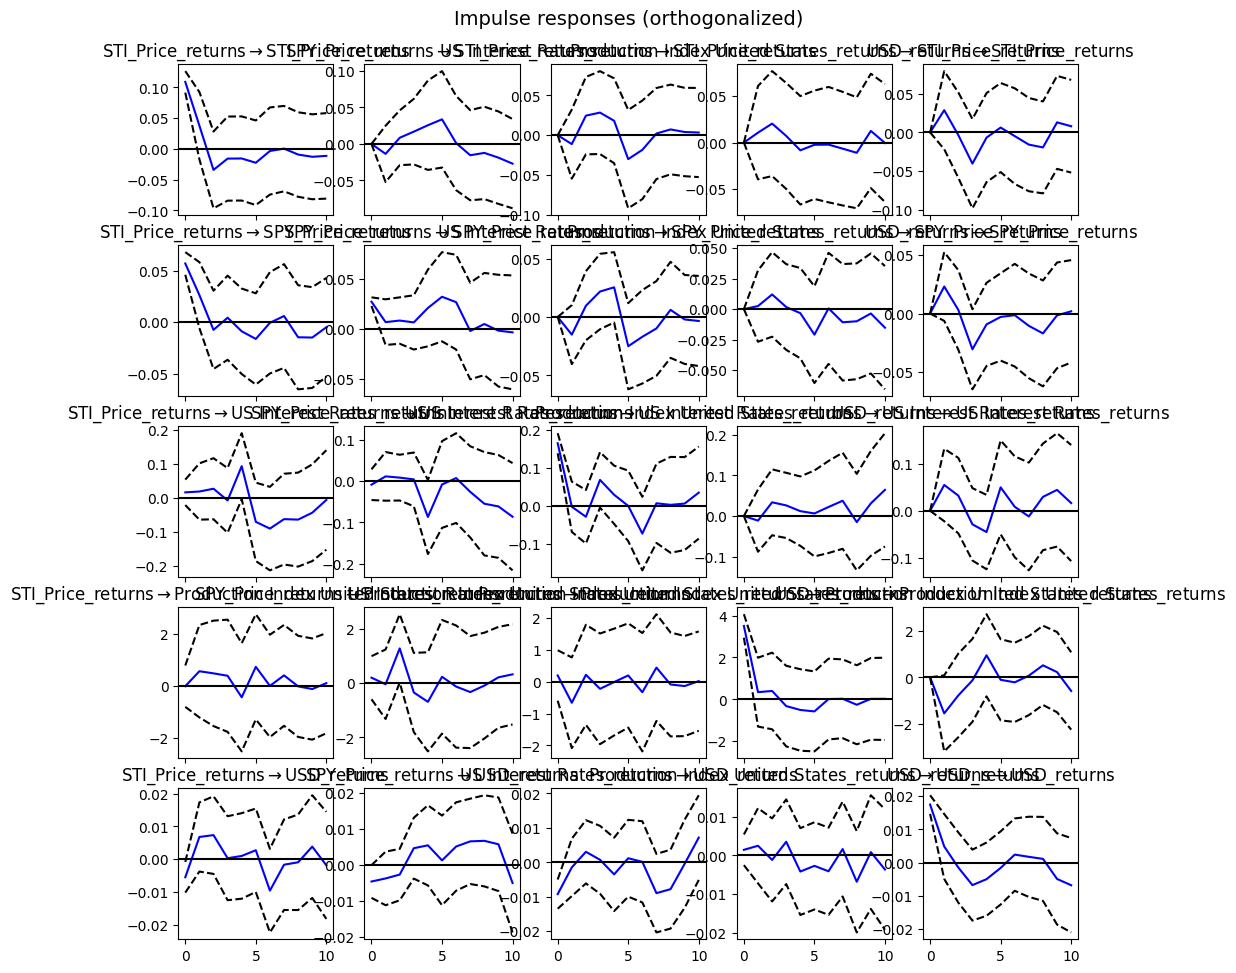

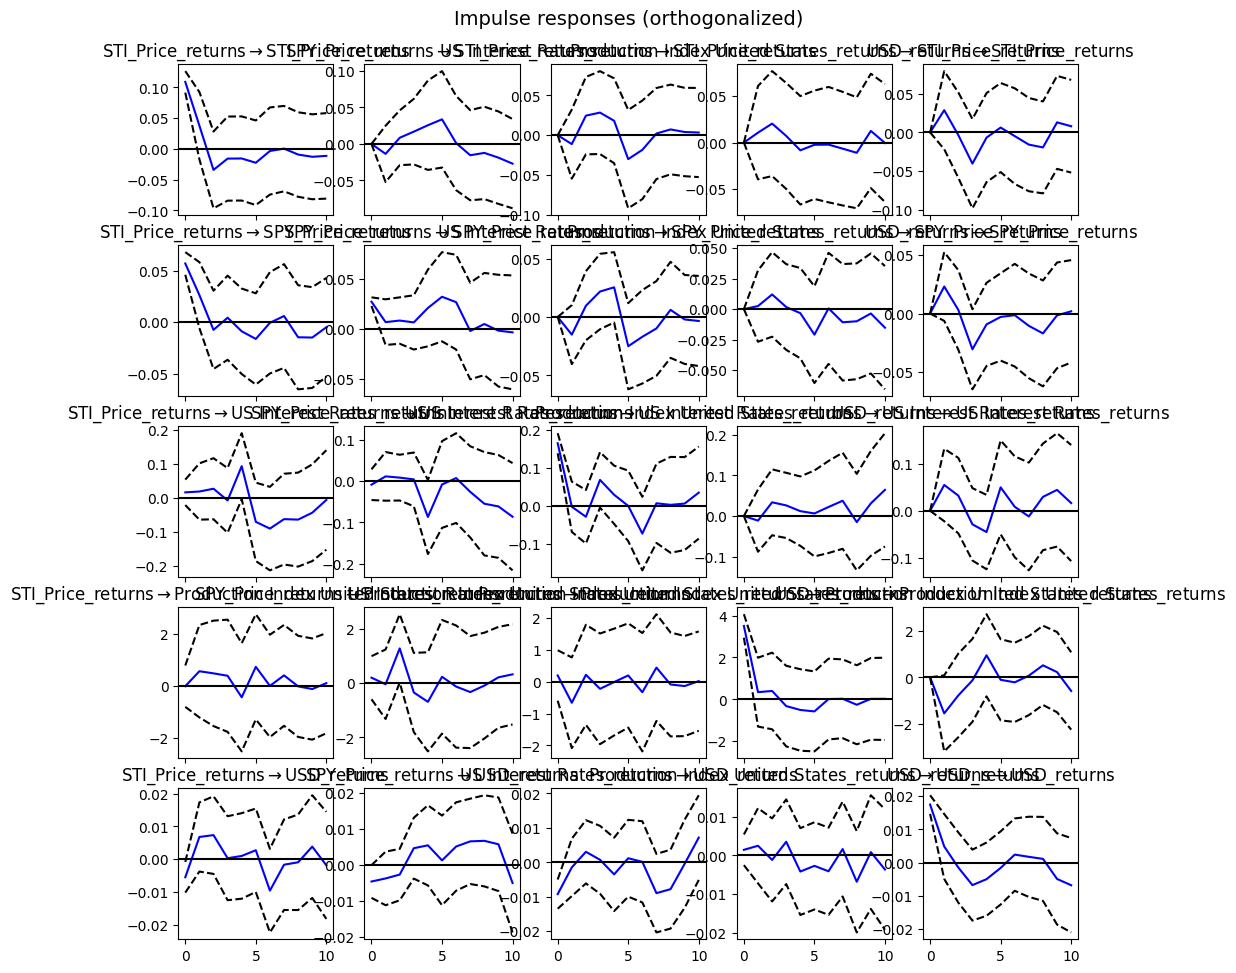

In [25]:
usa_irf = usa_model.irf(10)

usa_irf.plot(orth=True)

## ARDL Model

### Crisis Dummy Variables

In [26]:
import pandas as pd

# Assuming df is your DataFrame
df['Crisis'] = df['STI_Price_returns'] < -0.10

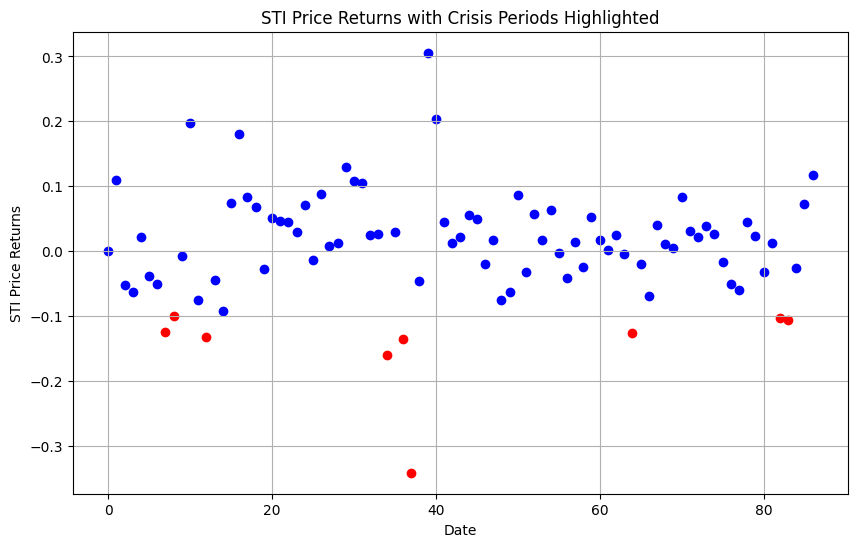

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot each point, color based on the Crisis column
for date, row in df.iterrows():
    if row['Crisis']:
        plt.scatter(date, row['STI_Price_returns'], color='red')
    else:
        plt.scatter(date, row['STI_Price_returns'], color='blue')

plt.xlabel('Date')
plt.ylabel('STI Price Returns')
plt.title('STI Price Returns with Crisis Periods Highlighted')
plt.grid(True)
plt.show()


In [28]:
crisis_dates = df[df['Crisis']]["Date"]
print("Dates when STI Price Returns were below 0.15:")
print(crisis_dates)

Dates when STI Price Returns were below 0.15:
7    2019-06-30
8    2019-03-31
12   2018-03-31
34   2012-09-30
36   2012-03-31
37   2011-12-31
64   2005-03-31
82   2000-09-30
83   2000-06-30
Name: Date, dtype: datetime64[ns]


## Quarterly Seasonality Check

In [29]:
import pandas as pd

# Assuming df is your DataFrame with a DateTime index
quarterly_grouped = df['STI_Price_returns'].groupby(pd.Grouper(freq='Q')).mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
quarterly_grouped.plot(kind='line', color='blue', marker='o', linestyle='-')
plt.title('Mean of STI Price Returns by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Mean Returns')
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns

# Creating a DataFrame suitable for Seaborn boxplot
df_boxplot = df.copy()
df_boxplot['Quarter'] = df_boxplot.index.to_period('Q')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Quarter', y='STI_Price_returns', data=df_boxplot, palette="Set3")
plt.title('Distribution of STI Price Returns by Quarter')
plt.xlabel('Quarter')
plt.ylabel('STI Price Returns')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping by quarter for mean
quarterly_mean = df['STI_Price_returns'].groupby(pd.Grouper(freq='Q')).mean()

# Mean line plot
plt.figure(figsize=(12, 6))
quarterly_mean.plot(kind='line', color='blue', marker='o', linestyle='-', label='Mean')

# Distribution box plot
df_boxplot = df.copy()
df_boxplot['Quarter'] = df_boxplot.index.to_period('Q')
sns.boxplot(x='Quarter', y='STI_Price_returns', data=df_boxplot, palette="Set3", fliersize=0)

plt.title('Mean and Distribution of STI Price Returns by Quarter')
plt.xlabel('Quarter')
plt.ylabel('STI Price Returns')
plt.legend()
plt.grid(True)
plt.show()
